## 2D code for diffusion simulation using Crank-Nicolson Method
Currently we have diffusion and agents moving with periodic BC.

$\frac{\partial u}{\partial t} = \kappa \nabla^2 u - \beta u + a1\sum_{i=1}^{N}\delta(\mathbf{x}-\mathbf{x_i})$

with periodic boundary conditions.

The above equation's 1D version using the CN can be written as a finite difference equation:
$$-\alpha u^{n+1}_{i-1} + (1+2\alpha+\beta\Delta t/2)u^{n+1}_{i} - \alpha u^{n+1}_{i-1}
=
\alpha u^{n}_{i-1} + (1-2\alpha-\beta\Delta t/2)u^{n}_{i} + \alpha u^{n}_{i-1}$$

<span style="color:blue">
There are some little typos in your explanation.  I am going to rework it here in blue. You have the sign flipped in the decay term.  In 2D, there is a 4 on the diagonal because it is $\nabla^2c = c_{xx} + c_{yy}$.
I prefer defining
$$
\alpha = \frac{\kappa \Delta t}{(\Delta x)^2},
$$
rather than
$$
\alpha = \frac{\kappa \Delta t}{2 (\Delta x)^2},
$$
For the rest of this, I will use my definition, but in your parts of the text, I'll leave it as you had it.
To go to 2D, we have
$$
(1+4\alpha/2+\beta\Delta t/2)u^{n+1}_{i,j} - \alpha/2 
\left(u^{n+1}_{i+1,j}+u^{n+1}_{i-1,j}+u^{n+1}_{i,j+1}+u^{n+1}_{i,j-1} \right)
= \\
(1+4\alpha/2-\beta\Delta t/2)u^{n}_{i,j} + \alpha/2
\left( u^{n}_{i+1,j}+u^{n}_{i-1,j}+u^{n}_{i,j+1}+u^{n}_{i,j-1}  \right)
$$
</span>

<span style="color:blue">
The Crank-Nicolson Matrix we will be using is as follows
$$M_{1} = 
\begin{bmatrix}
A_1 & -(\alpha/2) I & 0 & 0 & -(\alpha/2) I \\
-(\alpha/2) I & A_1 & -(\alpha/2) I & 0 & 0 \\
0 & -(\alpha/2) I & A_1 & -(\alpha/2) I & 0 \\
0 & 0 & -(\alpha/2) I & A_1 & -(\alpha/2) I \\
-(\alpha/2) I & 0 & 0 & -(\alpha/2) I & A_1
\end{bmatrix}$$
and
$$M_{2} = 
\begin{bmatrix}
A_2 & (\alpha/2) I & 0 & 0 & (\alpha/2) I \\
(\alpha/2) I & A_2 & (\alpha/2) I & 0 & 0 \\
0 & (\alpha/2)  I & A_2 & (\alpha/2) I & 0 \\
0 & 0 & (\alpha/2) I & A_2 & (\alpha/2) I \\
(\alpha/2) I & 0 & 0 & (\alpha/2) I & A_2
\end{bmatrix}$$
where the matrices $A_1$, $A_2$ are the 1D Crank-Nicolson matrices with periodic boundary condition
$$
A_1 = \begin{bmatrix}
1+2\alpha+\beta\Delta t/2 & -\alpha/2 & 0 & 0 & 0 & -\alpha/2\\
-\alpha/2 & 1+2\alpha+\beta\Delta t/2 & -\alpha/2 & 0 & 0 & 0\\
0 & -\alpha/2 & 1+2\alpha+\beta\Delta t/2 & -\alpha/2 & 0 & 0\\
0 & 0 & -\alpha/2 & 1+2\alpha+\beta\Delta t/2 & -\alpha/2 & 0\\
0 & 0 & 0 & -\alpha/2 & 1+2\alpha+\beta\Delta t/2 & -\alpha/2\\
-\alpha/2 & 0 & 0 & 0 & -\alpha/2 & 1+2(\alpha/2)+\beta\Delta t/2
\end{bmatrix}
$$
$$
A_2 = \begin{bmatrix}
1-2\alpha-\beta\Delta t/2 & \alpha/2 & 0 & 0 & 0 & \alpha/2\\
\alpha/2 & 1-2\alpha-\beta\Delta t/2 & \alpha/2 & 0 & 0 & 0\\
0 & \alpha/2 & 1-2\alpha-\beta\Delta t/2 & \alpha/2 & 0 & 0\\
0 & 0 & \alpha/2 & 1-2\alpha-\beta\Delta t/2 & \alpha/2 & 0\\
0 & 0 & 0 & \alpha/2 & 1-2\alpha-\beta\Delta t/2 & \alpha/2\\
\alpha/2 & 0 & 0 & 0 & \alpha/2 & 1-2\alpha-\beta\Delta t/2
\end{bmatrix}
$$
</span>

The linear equation system we are trying to solve is
$$
M_1 \cdot [u^{n+1}] = M_2 \cdot [u^{n}] + \sum_{i=0}^N f_i \Delta t
$$
where the direc-delta function is 
$$
\delta(x,y) = \frac{1}{2\pi \sigma^2}\exp -{\frac{(x-x_avg)^2+(y-y_avg)^2}{4\sigma^2}}
$$


In [3]:
from scipy import *
import scipy.sparse as sp
import numpy as np
from scipy.interpolate import griddata
from scipy.sparse.linalg import spsolve
from numpy.random import rand
import matplotlib.pyplot as plt
import matplotlib.animation

%matplotlib notebook

In [2]:
class Background_Field(object):
    "A class that creates the background concentration field and evolves"
    
    # class builder initiation 
    def __init__(self,N=30,kappa=1.0e-4,beta=1.0e0,k=0.1,*args,**kwargs):
        self.N = N # The number of mesh points
        self.kappa = kappa
        self.beta  = beta
        self.k     = k # k is delta t
        self.x = r_[0:1:1j*self.N]# setup the spatial mesh. It is a long row vector

        # Create some local coordinates for the square domain.
        self.y = 1*self.x
        self.xm,self.ym = np.meshgrid(self.x,self.y)
        
        self.scalar = self.x
        for counter in range(0,self.N-1):
            self.scalar = np.append(self.scalar,self.x)
        
        self.h = self.x[1]-self.x[0] # spacial mesh size
        self.SetAlpha()
        self.BuildMatrixA1()
        self.BuildMatrixA2()
        self.BuildMatrices() # build M1 and M2
    
    # Forward one time step. Just diffuse
    def Update(self, vectors): # Remark: we feed in all info, but only those flagged
        # will be emitting substances to change the background field
        
        self.scalar = spsolve(self.M1, self.M2.dot(vectors))

        return self.scalar
    
    # Set up initial condition
    def SetIC(self,f):
        ic = f(self.xm,self.ym)
        ic = ic.reshape((self.N**2,))
        self.IC = ic
        self.scalar = ic
        
    def Meshed(self):
        return(self.scalar.reshape((self.N,self.N)))
        
    # Compute alpha
    def SetAlpha(self):
        self.alpha = self.kappa*self.k/self.h/self.h
        self.BuildMatrixA1()
        self.BuildMatrixA2()
        self.BuildMatrices()
        
    def SetBeta(self,beta):
        self.beta = beta
        self.BuildMatrixA1()
        self.BuildMatrixA2()
        self.BuildMatrices()
        
    # Build the N x N matrix A1 for 1-Dimensional Crank-Nicoleson Method
    def BuildMatrixA1(self):
        diag = ones(self.N)*(1+4*self.alpha/2+self.k*self.beta/2)
        data = np.array([-ones(self.N)*self.alpha/2,-ones(self.N)*self.alpha/2,
                         diag, -ones(self.N)*self.alpha/2,-ones(self.N)*self.alpha/2]) #off-diag and corners are -alpha
        self.A1 = sp.spdiags(data,[1-self.N,-1,0,1,self.N-1],self.N,self.N)
        
    def BuildMatrixA2(self):
        diag = ones(self.N)*(1-4*self.alpha/2-self.k*self.beta/2)
        data = np.array([ones(self.N)*self.alpha/2, ones(self.N)*self.alpha/2,
                         diag, ones(self.N)*self.alpha/2, ones(self.N)*self.alpha/2]) #off-diag and corners are alpha
        self.A2 = sp.spdiags(data,[1-self.N,-1,0,1,self.N-1],self.N,self.N)
    
    # Build the big matrices M1 M2 using I, A1 and A2
    def BuildMatrices(self):
        ############ Build M1
        self.I = sp.identity(self.N) # Identity N x N Sparse Matrix
        self.E = sp.csr_matrix((self.N,self.N)) # Zero N x N Sparse Matrix
        Rows = {i: self.E for i in range(self.N)} # Empty rows of tile matrices
        Rows[0] = self.A1
        Rows[1] = -self.I*self.alpha/2
        Rows[self.N-1] = -self.I*self.alpha/2
        # Creating rows
        for i in range(self.N):
            for j in range(1,self.N):
                if j == i:
                    buildblock = self.A1
                elif j == (i-1 % self.N) or j == (i+1 % self.N) or (j==self.N-1 and i==0): # a cheap way to fix
                    buildblock = -self.I*self.alpha/2
                else:
                    buildblock = self.E
                Rows[i] = sp.hstack([Rows[i],buildblock]) # Stack matrices horizontally to create rows
                
        # Stack rows together vertically to get M1
        self.M1 = Rows[0]
        for i in range(1,self.N):
            self.M1 = sp.vstack([self.M1,Rows[i]])
        self.M1 = self.M1.tocsr()    
        ############ Build M2
        Rows = {i: self.E for i in range(self.N)} # Empty rows of tile matrices
        Rows[0] = self.A2
        Rows[1] = self.I*self.alpha/2
        Rows[self.N-1] = self.I*self.alpha/2
        # Creating rows
        for i in range(self.N):
            for j in range(1,self.N):
                if j == i:
                    buildblock = self.A2
                elif j == (i-1 % self.N) or j == (i+1 % self.N) or (j==self.N-1 and i==0): # a cheap way to fix
                    buildblock = self.I*self.alpha/2
                else:
                    buildblock = self.E
                Rows[i] = sp.hstack([Rows[i],buildblock]) # Stack matrices horizontally to create rows
                
        # Stack rows together vertically to get M2
        self.M2 = Rows[0]
        for i in range(1,self.N):
            self.M2 = sp.vstack([self.M2,Rows[i]])
        self.M2 = self.M2.tocsr()
        
    def CheckM():
        checkmatrix = self.M1.toarray()
        print(np.array2string(checkmatrix,precision=2))
        checkmatrix = self.M2.toarray()
        print(np.array2string(checkmatrix,precision=2))
        
    def CheckA():
        checkmatrix = self.A1.toarray()
        print(np.array2string(checkmatrix,precision=2))
        checkmatrix = self.A2.toarray()
        print(np.array2string(checkmatrix,precision=2))


## Implementing run and tumble.

Plankton move with random speed $\vec{v_i}$ and speed $s = |\vec{v}_i|$.  They tumble with probability $P$.

$$
P = \frac{\lambda_0}{2}(1-\alpha \ \vec{v}_i \cdot \nabla u)
$$

Currently, $\alpha = \left(|\vec{v}_i| |\nabla u| + \epsilon \right)^{-1}$ where $\epsilon$ is a small regularization parameter just in case $|\nabla u|$ or $|\vec{v}|$ is close to zero.

Bearson and Pedley (BMB, 2000) propose a different model where $\alpha$ is proportional to $|\nabla u|$. Instead of using $\vec{v}_i$ on the right hand side, they use the swimmer direction so $\vec{v}_i/|\vec{v}_i|$.


In [3]:
class Plankton(Background_Field):
    
    def __init__(self,depFcn,lambda0=1e0,speed=0.1,depMaxStr=1.0e-10,depVar=1.0e-5,epsilon=1.0e-8,*args,**kwargs):

        self.lambda0 = lambda0
        self.speed = speed
        self.depMaxStr = depMaxStr #Deposition maximum strength
        self.depVar = depVar       #Deposition variable (Gaussian deposition)
        self.depFcn = depFcn
        self.args = args
        self.kwargs = kwargs
        
        self.epsilon = epsilon

        super(Plankton,self).__init__(*args,**kwargs)

        print('Exact deposition variance: {0:8.2e}, length scale: {1:8.2e}.  a2: {2:8.2e}.'.format(self.k*self.kappa,
                                                                                             sqrt(self.k*self.kappa),
                                                                                             self.depVar))
        
    def RT(self,pos,vel,c,grad_c):
        # Actually, I need to do this as tumble and run, TR.
        for j in range(0,len(pos)):
            alpha = 1/(self.epsilon + sqrt(grad_c[j].dot(grad_c[j])*vel[j].dot(vel[j])))
            if (rand() < self.k*self.lambda0*0.5*(1-alpha*grad_c[j].dot(vel[j]))):
                th = rand()*2*pi
                vel[j] = self.speed*array([cos(th),sin(th)])
        for j in range(0,len(pos)):
            pos[j] += self.k*vel[j]
            pos[j] = mod(pos[j],1)
        
    def Update(self,vectors,pos,vel):
        c      = self.scalarInterp(pos)
        grad_c = self.scalarGrad(pos)
        self.RT(pos,vel,c,grad_c)
        
        depStr = self.depFcn(c,self.depMaxStr,*self.args,**self.kwargs)
        f = zeros((self.N,self.N))
        for p,str in zip(pos,depStr):
            f = f + str*exp(-((self.xm-p[0])**2+(self.ym-p[1])**2)/4/self.depVar)/(4*pi*self.depVar)
            # Be cautious about periodic BC's.
            # We capture periodic source emissions.
            # Assumes a [0,1]x[0,1] domain.
            if (p[0]<8*sqrt(self.depVar)):
                f = f + str*exp(-((self.xm-p[0]-1)**2+(self.ym-p[1])**2)/4/self.depVar)/(4*pi*self.depVar)
            if (p[0]>1-8*sqrt(self.depVar)):
                f = f + str*exp(-((self.xm-p[0]+1)**2+(self.ym-p[1])**2)/4/self.depVar)/(4*pi*self.depVar)
            if (p[1]<8*sqrt(self.depVar)):
                f = f + str*exp(-((self.xm-p[0])**2+(self.ym-p[1]-1)**2)/4/self.depVar)/(4*pi*self.depVar)
            if (p[1]>1-8*sqrt(self.depVar)):
                f = f + str*exp(-((self.xm-p[0])**2+(self.ym-p[1]+1)**2)/4/self.depVar)/(4*pi*self.depVar)
        f = f.reshape((self.N*self.N,))
        self.scalar = spsolve(self.M1, self.M2.dot(vectors)+self.k*f)
        return(self.scalar)
    
    def scalarInterp(self,p):
        return(griddata((self.xm.reshape(self.N**2,),self.ym.reshape(self.N**2,)),self.scalar,p,method='cubic'))

    # Assumes a [0,1]x[0,1] domain.
    def scalarGrad(self,xp,dx=1.0e-4):
        dp = array(self.scalarInterp([mod(xp + array([dx,0]),1),mod(xp - array([dx,0]),1),mod(xp + array([0,dx]),1),
                                      mod(xp - array([0,dx]),1)]))
        diffs = array([dp[0]-dp[1],dp[2]-dp[3]])/2/dx
        diffs = diffs.T
        return(diffs)


In [5]:
def constantDep(c,depMaxStr,**kwargs):
    '''Constant deposition function'''
    return(array(depMaxStr*ones(len(c))))

def atanDep(c,depMaxStr,depThreshold=0.08,depTransWidth=1/250,**kwargs):
    '''arctan (soft switch) transition function'''

    return(depMaxStr/pi*(arctan((-c+depThreshold)/depTransWidth)+pi/2))

def linAtanDep(c,depMaxStr,depThreshold=0.08,depTransWidth=1/250,**kwargs):
    '''arctan (soft switch) transition function'''

    return(depMaxStr/pi*(c+0.1*depThreshold)/1.1/depThreshold*(arctan((-c+depThreshold)/depTransWidth)+pi/2))


# RT swimmers in a background field

Set up some basic initial conditions.

**Caution:** All length scales should be roughly the same or something is going to be underresolved.

In [ ]:
meshsize = 40
print('Mesh length scale: {0:8.2e}'.format(1/meshsize))
Swimmers = Plankton(atanDep,N = meshsize,depMaxStr=1.0e-4,depVar=4.0e-4,k=0.02,speed=0.05,
                    lambda0=1.0,kappa=6.4e-3,beta=0.25,depTransWidth=1/250,depThreshold=0.08)

def initial_conditions(x,y):
    return(0*x)

Swimmers.SetBeta(1.0)


In [6]:
meshsize = 40
print('Mesh length scale: {0:8.2e}'.format(1/meshsize))
Swimmers = Plankton(linAtanDep,N = meshsize,depMaxStr=2.0e-4,depVar=4.0e-4,k=0.02,speed=0.05,
                    lambda0=1.0,kappa=6.4e-3,beta=0.25,depTransWidth=0.001,depThreshold=0.08)

def initial_conditions(x,y):
    return(0*x)

Swimmers.SetBeta(1.0)


Mesh length scale: 2.50e-02
Exact deposition variance: 1.28e-04, length scale: 1.13e-02.  a2: 4.00e-04.


Initialize the scalar field.  Lay out some particles.

<IPython.core.display.Javascript object>


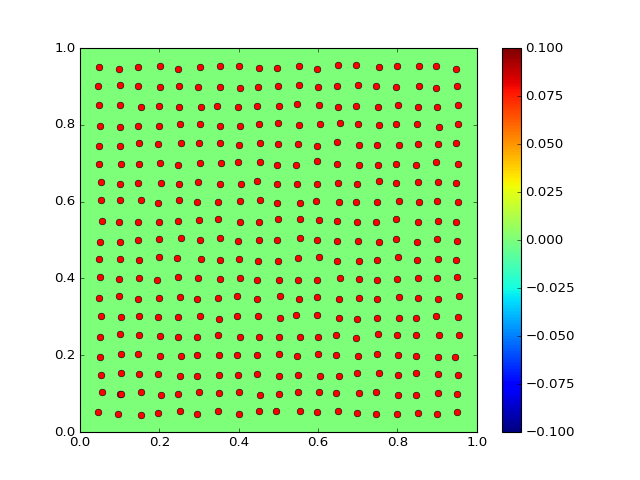

In [7]:
Swimmers.SetIC(initial_conditions)

pos = [array([0.1,0.1])]
th = rand()*2*pi
vel = [Swimmers.speed*array([cos(th),sin(th)])]
for l in range(0,19):
    for k in range(0,19):
        pos = np.append(pos,[array([k*0.05 + 0.01*(rand()-0.5) + 0.05,
                                  l*0.05 + 0.01*(rand()-0.5) + 0.05])],axis=0)
        th  = rand()*2*pi
        vel = np.append(vel,[Swimmers.speed*array([cos(th),sin(th)])],axis=0)

plt.figure()
plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
plt.plot(pos[:,0],pos[:,1],'ro')
plt.colorbar()
plt.show()

Simulate the system.  The upper value of the inner loop can be adjusted as needed.  The inner value of 1000 is a pretty long simulation.

In [ ]:
pos_store = list([pos[:,:]])
pos_store = list([np.array(pos)])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,200):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
    plt.plot(pos[:,0],pos[:,1],'ro')
    plt.title('Plot {0:d}'.format(plot))
    plt.colorbar()

plt.show()

Another sim varying $\lambda_0$.

<IPython.core.display.Javascript object>


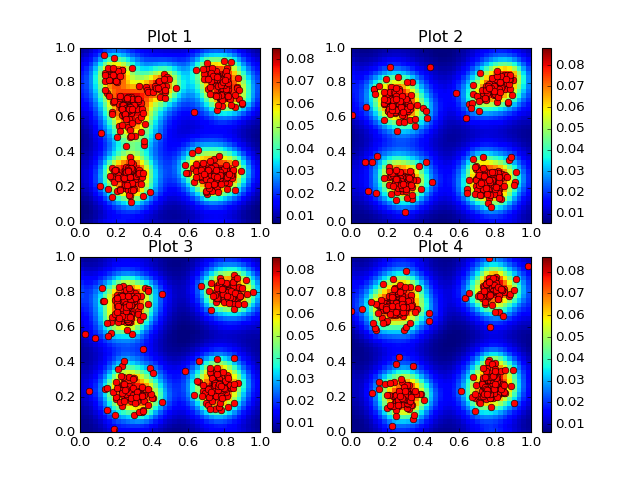

In [8]:
Swimmers.lambda0 = 3.0

pos_store = list([pos[:,:]])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,1000):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
    plt.plot(pos[:,0],pos[:,1],'ro')
    plt.title('Plot {0:d}'.format(plot))
    plt.colorbar()

plt.show()

In [ ]:
Swimmers.lambda0 = 10.0

pos_store = list([pos[:,:]])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,1000):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
    plt.plot(pos[:,0],pos[:,1],'ro')
    plt.title('Plot {0:d}'.format(plot))
    plt.colorbar()

plt.show()

### Include phototactic effects.

Another sim varying $\lambda_0$ and with bias in orientation.
$$
P = \frac{\lambda_0}{2}(1-\alpha \ \vec{v}_i \cdot \nabla u) \left(1-\frac{(\vec{v}_i \cdot [1,0]^T)^2}{|\vec{v}_i|^2}\right)
$$


In [ ]:
meshsize = 40
print('Mesh length scale: {0:8.2e}'.format(1/meshsize))
Swimmers = PlanktonPhoto(N = meshsize,a1=1.0e-4,a2=4.0e-4,k=0.02,speed=0.05,
                        lambda0=1.0,kappa=6.4e-3,beta=0.25)

def initial_conditions(x,y):
    return(0*x)

Swimmers.SetBeta(1.0)

In [ ]:
Swimmers.SetIC(initial_conditions)

pos = [array([0.1,0.1])]
th = rand()*2*pi
vel = [Swimmers.speed*array([cos(th),sin(th)])]
for l in range(0,19):
    for k in range(0,19):
        pos = np.append(pos,[array([k*0.05 + 0.01*(rand()-0.5) + 0.05,
                                  l*0.05 + 0.01*(rand()-0.5) + 0.05])],axis=0)
        th  = rand()*2*pi
        vel = np.append(vel,[Swimmers.speed*array([cos(th),sin(th)])],axis=0)

plt.figure()
plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
plt.plot(pos[:,0],pos[:,1],'ro')
plt.colorbar()
plt.show()

In [ ]:
Swimmers.lambda0 = 3.0

pos_store = list([pos[:,:]])
scalar_store = list([Swimmers.Meshed()])

plt.figure()

for plot in range(1,5):
    for k in range(0,400):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
    plt.subplot(2,2,plot)
    plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
    plt.plot(pos[:,0],pos[:,1],'ro')
    plt.title('Plot {0:d}'.format(plot))
    plt.colorbar()

plt.show()

### Animation

This routine animates the particle position and scalar field data.
Honestly, I still do not completely understand why this works and other things that I tried did not work.  Be careful about returning axis objects with or without a comma.  It seems to cause a problem sometimes one way and sometimes the other (**"return field"** not "return field,"; but **"return dots,"** not "return dots").

In [ ]:
fig   = plt.figure()
ax    = plt.subplot(1,1,1)
field = ax.pcolormesh(Swimmers.xm,Swimmers.ym,scalar_store[1])
field.set_clim(0,0.08)
dots, = ax.plot([], [], 'ro')
fig.colorbar(field)

def initit():
    dots.set_data([], [])
    return field,dots

def animate(k):
    arr = scalar_store[k]
    arr = arr[:-1, :-1]
    field.set_array(arr.ravel())
    plt.title('Frame {0:d}'.format(k))
    dots.set_data(pos_store[k][:,0],pos_store[k][:,1])

    return field,dots,
    
anim = matplotlib.animation.FuncAnimation(fig,animate,frames=range(0,len(scalar_store),4),
                                          interval=50,blit=False,repeat=True)

# Uncomment if you want to save it to a file.  Requires mencoder or ffmpeg or some writer utility to generate the file.
anim.save('basic_animation.mp4', writer='ffmpeg')
plt.show()


### Simple animation

This routine animates the particle position data.


In [ ]:
fig   = plt.figure()
ax    = plt.axes(xlim=(0, 1), ylim=(0, 1))
dots, = ax.plot([], [], 'ro')

def initit():
    dots.set_data([], [])
    return dots,

def animate(k):
    dots.set_data(pos_store[k][:,0],pos_store[k][:,1])
    return dots,
    
anim = matplotlib.animation.FuncAnimation(fig, animate,init_func=initit,
                               frames=len(pos_store), interval=50, blit=True, repeat=True)

#anim.save('basic_animation.mp4', writer='mencoder')
plt.show()


#### Saving data.

In [ ]:
savez('plankton_sim_linAtan_lam_3.0',pos_store,scalar_store)

#### Loading in data.

In [ ]:
npzfile = load('plankton_sim_lam_1.0.npz')
print(npzfile.files)
pos_store = npzfile['arr_0']
scalar_store = npzfile['arr_1']


In [ ]:
c = r_[0:0.15:1000j]
plt.figure()
plt.plot(c,(c+0.01)/0.11*atanDep(c,0.1,depTransWidth=0.001))
plt.grid()
plt.show()

In [30]:
A = np.array([1,2,3,4])

In [31]:
l = list([A])

In [32]:
B = reshape(np.array(A),(2,2))

In [33]:
B

array([[1, 2],
       [3, 4]])

In [34]:
A

array([1, 2, 3, 4])

In [35]:
l.append(B)

In [36]:
l

[array([1, 2, 3, 4]), array([[1, 2],
        [3, 4]])]

In [37]:
A[3]=-1

In [38]:
l

[array([ 1,  2,  3, -1]), array([[1, 2],
        [3, 4]])]